##### Syed Ali Alim Rizvi

# Multiclass Perceptron

In [4]:
library(reshape2)
library(ggplot2)
library(tidyr)

Warning message:
"package 'reshape2' was built under R version 3.5.1"Warning message:
"package 'ggplot2' was built under R version 3.5.1"
Attaching package: 'tidyr'

The following object is masked from 'package:reshape2':

    smiths



#### Data Import

In [5]:
t1d.train <- read.csv('MulticlassPerceptron_train.csv')
t1d.test <- read.csv('MulticlassPerceptron_test.csv')

#### Functions

In [6]:
#input variables defined under play.mc.perceptron
#error function - calculate error over data for given tau and weight list
get.error <- function(Phi, W.list, T, train.len, tau, which=0){

# function(Phi, W.list, T, train.len, tau, which=0)
# Description: gets the total error of all data points using the most updated weights for all Class vectors
# Input: 
#     Phi: The Data Matrix
#     W.list: List containing the weight vectors
#     T: The true labels for the Data Matrix Phi
#     Train.len: Total data points in the Data Matrix
#     Tau: the list of updated indexes for each class weight matrix
#     Which: which lag to check error for (e.g. -1 implies use the previous weights not the current ones)
# Output:
#     Error: error of the data set with the current weights in %

    
    # total true
    tot.true <- 0

    #for each data point evaluate max with updated wieghts and check how many are correct
    for (i in 1:train.len) {
        #pred.result <- which.max(c((Phi[i,]%*%W.list$W1[tau[1]+which,]), (Phi[i,]%*%W.list$W2[tau[2]+which,]), (Phi[i,]%*%W.list$W3[tau[3]+which,])))==T[i]
        if (which.max(c((Phi[i,]%*%W.list$W1[tau[1]+which,]), (Phi[i,]%*%W.list$W2[tau[2]+which,]), (Phi[i,]%*%W.list$W3[tau[3]+which,])))==T[i]){
        tot.true <- tot.true + 1
        }
    }
    
    #get percentage of false
    tau.error <- (train.len - tot.true)/train.len*100 
    
    return(tau.error)
}

In [7]:
class.predict <- function(Phi, W.list, i, tau) {

#    function(Phi, W.list, i, tau)
#    Description: Predicts the class for the ith data vector using the current weights
#    Input: 
#        Phi: The Data Matrix
#        W.list: List containing the weight vectors
#        i: ith data vector from Phi
#        tau: the list o fupdated indexes for each class weight matrix
#    Output:
#        The predicted class for the ith data point.

    
    #get argmax class from W.list weights and the ith data vector from Phi
    class <- which.max(c((Phi[i,]%*%W.list$W1[tau[1],]), (Phi[i,]%*%W.list$W2[tau[2],]), (Phi[i,]%*%W.list$W3[tau[3],])))
    
    #return the class
    return(class)
}

In [8]:
update.weight <- function(Phi, W.list, pred.class, true.class, i, tau, eta) {

# function(Phi, W.list, pred.class, true.class, i, tau, eta)
# Description: reduces weights for the predicted class and increases the weights for the correct class 
# Input:
#     Phi: Data Matrix
#     W.list: List containing the weight vectors
#     pred.class: predicted class
#     true.class: true class
#     i: ith data vector of data matrix
#     tau: the list of updated indexes for each class weight matrix
#     eta: learning rate
# Output:
#     Updated weight vectors

    
    #reduce score for wrong weight class (predicted class weights)
    W.list[[pred.class]][tau[pred.class],] <- W.list[[pred.class]][tau[pred.class]-1,] - eta * Phi[i,]

    #increase score for correct weight class (the correct labelled class i.e. T[i])
    W.list[[true.class]][tau[true.class],] <- W.list[[true.class]][tau[true.class]-1,] + eta * Phi[i,]
    
    #returne updated Weight list
    return(W.list)
}

In [17]:
play.mc.perceptron <- function(train.data, train.label, test.data, test.label, eta=0.01, tau.max=500, epsilon=NULL) {

# function(train.data, train.label, test.data, test.label, eta=0.01, epsilon=0.001, tau.max=500)
# Description: runs the multiclass perceptron with K discriminants model with the given inputs
# Inputs:
#     train.data: Train data without the class labels
#     train.label: class labels for the train.data
#     test.data: test data without class labels
#     test.label: class labels for the test.data
#     eta: the initial learning rate (default: 0.01)
#     epsilon: min error to evalute the stopping condition 
#     tau.max: maximum number of weight updates to be allowed (default: 500)
# Output: A named list containing the following objects
#     W.list: the list of vector matrices used for the model
#     err.train: a 1 column matrix containing the training data error after each mini-batch of 5 records
#     err.test: a 1 column matrix containing the testing data error after each mini-batch of 5 records
#     tau: the updated tau matrix containg current indexes for (c1, c2, c3, total updates)
#     exit.cond: the condition that caused the perceptron model to stop
# custom functions used internally:
#     update.weight()
#     class.predict()
#     get.error()
    
    
    #--------------------------------------------------------
    ## Basis function 
    Phi <- as.matrix(cbind(1, train.data)) # add a column of 1 as phi_0
    
    #--------------------------------------------------------
    # Initialization
    train.len <- dim(train.data)[1]
    eta <- eta # Learning rate
    epsilon <- epsilon # Stoping criterion
    tau.max <- tau.max #train.len # Maximum number of iterations equal to data set (go through it once)
    T <- as.numeric(train.label) # convert class labels to numbers (c1=1, c2=2, c3=3)

    #create weights for each class 
    W1 <- W2 <- W3 <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector class 1,2,3
    W1[1,] <- runif(ncol(Phi)) # Random initial values for weight vectors class 1
    W2[1,] <- runif(ncol(Phi)) # Random initial values for weight vectors class 2
    W3[1,] <- runif(ncol(Phi)) # Random initial values for weight vectors class 3
    W.list <- list(W1=W1, W2=W2, W3=W3) #create a list of weights

    error.trace <- matrix(, ncol=1) # Placeholder for errors (empty)
    tau <- matrix(c(1,1,1,1),ncol=4) #list of taus (c1,c2,c3,total taus)
    terminate <- FALSE # termination status
    
    #--------------------------------------------------------
    # Initialize for test
    Phi.test <- as.matrix(cbind(1, test.data)) # add a column of 1 as phi_0
    T.test <- as.numeric(test.label) # convert class labels to numbers (c1=1, c2=2, c3=3)
    error.trace.test <- matrix(, ncol=1) # Placeholder for errors of testing data (empty)
    test.len <- dim(test.data)[1]
    
    #--------------------------------------------------------
    # START MULTICLASS PERCEPTRON
    
    #how many times the data has been cycled
    data.cycle <- 0

    # Main Loop (Step 2):
    while(!terminate){

        # resuffling train data and associated labels:
        train.index <- sample(1:train.len, replace = FALSE)
        Phi <- Phi[train.index,]
        T <- T[train.index]

        #for all datapoints
        for (i in 1:train.len){
            
            if (tau[4] == tau.max) {break}

            # look for missclassified samples

            #get predicted class and true class
            pred.class <- class.predict(Phi, W.list, i, tau)
            true.class <- T[i]

            #if predicted class is not correct
            if (pred.class!=true.class){

                # update tau counter for total tau, incorrect class and true class
                tau[c(pred.class, true.class, 4)] <- tau[c(pred.class, true.class, 4)] + 1

                # update the weights
                W.list <- update.weight(Phi, W.list, pred.class, true.class, i, tau, eta)
                
                # decrease eta:
                eta = eta * 0.99
            }
            

            # update the error records if mini-batch of has occured
            if (i%%5==0) {
                
                #calculate error for tau          
                tau.error <- get.error(Phi, W.list, T, train.len, tau)
                tau.error.test <- get.error(Phi.test, W.list, T.test, test.len, tau)
                
                #store error
                error.trace <- rbind(error.trace, tau.error)
                error.trace.test <- rbind(error.trace.test, tau.error.test)
            }
        }



        #check epsilon condition (only store anser if epsilon is not null else keep FALSE)
        epsilon.condition <- (get.error(Phi, W.list, T, train.len, tau) <= 1 )
        
        # recalculate termination conditions
        terminate <- (tau[4] >= tau.max) | (epsilon.condition) #less than 1 percent

        #add to data cycle since data has finished
        data.cycle <- data.cycle + 1
        
    }
    
    #--------------------------------------------------------
    #finilise objects to return for output

    #get exit condition for while break condition
    exit.condition <- ifelse(epsilon.condition, paste('min error condition met after data cyles:', data.cycle), paste('tau.max reached at',tau[4]))
    
    # cut the empty part of the matrix (when the loop stops before tau == tau.max)
    for (i in 1:3) {
        W.list[[i]] <- W.list[[i]][1:tau[i],]
    }
    
    #clean err train and test matrices
    rownames(error.trace) <- NULL
    rownames(error.trace.test) <- NULL
    
    #return output
    return(list(W=W.list, err.train=error.trace, err.test=error.trace.test, tau=tau, exit.cond=exit.condition, data.cycles=data.cycle))
    }

### Running Multiclass Perceptron

In [18]:
# get the train and test data

#train and test data
train.data <- t1d.train[,-5]
train.label <- t1d.train[,5]
test.data <- t1d.test[,-5]
test.label <- t1d.test[,5]

In [19]:
#initialize seed for reproducibility
set.seed(123)

#get results of mc.perceptron on our data
mc.perceptron.result <- play.mc.perceptron(train.data, train.label, test.data, test.label, eta=0.09, tau.max=1000, epsilon=NULL)

In [20]:
#check what all we have in the result
names(mc.perceptron.result)

[1] "W"           "err.train"   "err.test"    "tau"         "exit.cond"  
[6] "data.cycles"

In [21]:
#check exit condition
mc.perceptron.result$exit.cond
mc.perceptron.result$tau
mc.perceptron.result$data.cycles

[1] "min error condition met after data cyles: 60"

27,317,303,323


[1] 60

In [22]:
final.weights <- matrix(,nrow=3,ncol=5)
initial.weights <- matrix(,nrow=3,ncol=5)
for (i in 1:3) {
    final.weights[i,] <- mc.perceptron.result$W[[i]][mc.perceptron.result$tau[i],]
    initial.weights[i,] <- mc.perceptron.result$W[[i]][1,]
}
rownames(final.weights) <- c('W1', 'W2', 'W3')
rownames(initial.weights) <- c('W1', 'W2', 'W3')

print('final weights')
final.weights
print('initial weights')
initial.weights

[1] "final weights"


W1,0.5119147,1.2767459,1.5138941,-0.9016236,0.06351794
W2,0.3479644,1.1118607,0.9135165,0.3581965,-0.37643582
W3,0.4300883,-0.6188619,-0.4484440,2.5505130,1.81292458


[1] "initial weights"


W1,0.2875775,0.7883051,0.4089769,0.8830174,0.9404673
W2,0.0455565,0.5281055,0.8924190,0.5514350,0.4566147
W3,0.9568333,0.4533342,0.6775706,0.5726334,0.1029247


Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

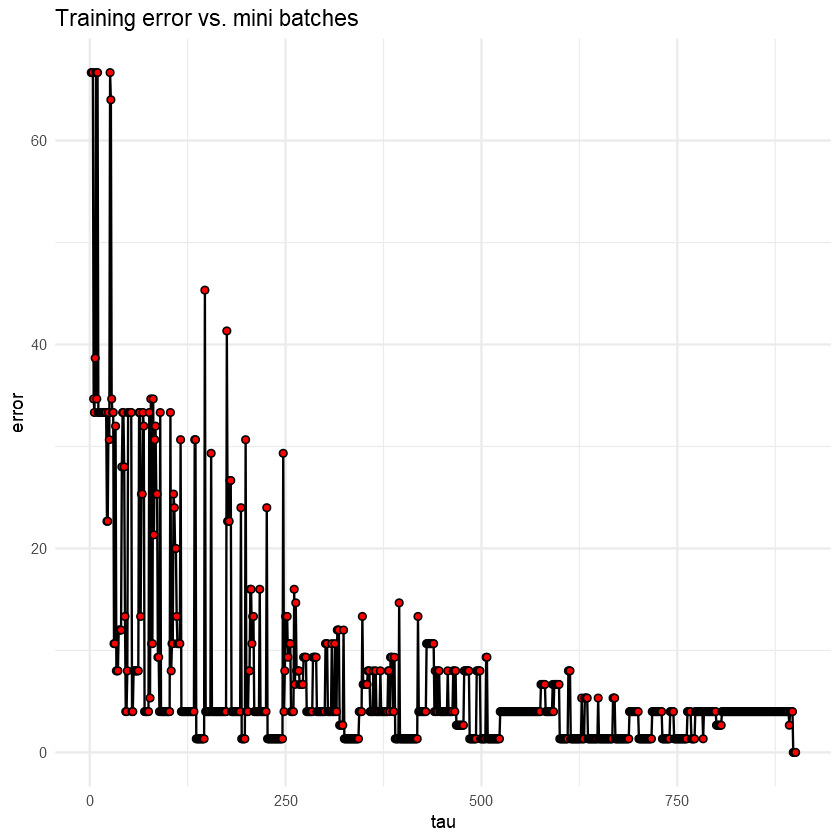

In [23]:
## merging and melting for visualizations
out <- data.frame('tau'=1:dim(mc.perceptron.result$err.train)[1])
out$error <- mc.perceptron.result$err.train
# out[,c('w0', 'w1', 'w2', 'w3')] <- W

# out.m <- melt(out, id=c('tau', 'error'))
# names(out.m) <- c('tau', 'error', 'W', 'coefficient')

## Training error
ggplot(data=out,aes(x=tau, y=error)) + geom_line() + geom_point(shape=21, fill='red')  + 
    ggtitle('Training error vs. mini batches') + theme_minimal()

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

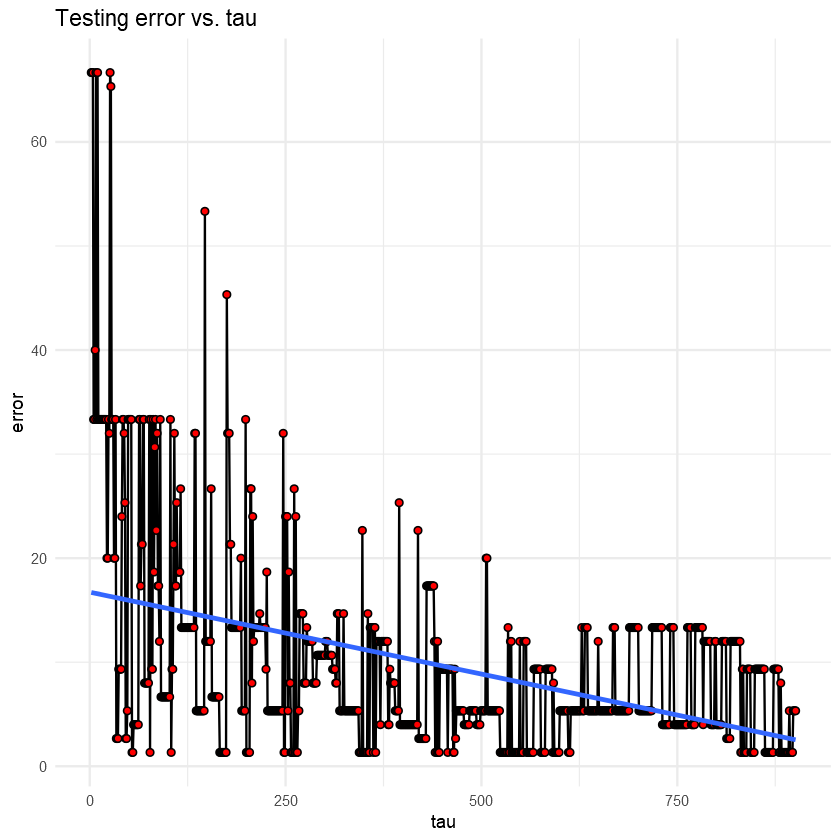

In [24]:
## merging and melting for visualizations
out <- data.frame('tau'=1:dim(mc.perceptron.result$err.test)[1])
out$error <- mc.perceptron.result$err.test

## Training error
ggplot(data=out,aes(x=tau, y=error))+  geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Testing error vs. tau') + theme_minimal()  + geom_smooth(method='lm',formula=y~x, se=F)